In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
import numpy as np
import pandas as pd
import sys
sys.path.append("..")

from torch.utils import data

import glob
import random
import os
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

from bokeh.io import push_notebook, show, output_notebook,reset_output
from bokeh.plotting import figure
import networkx as nx
from bokeh.plotting import figure, from_networkx, curdoc
from bokeh.models import Rect, HoverTool,  TextInput, GraphRenderer, Circle
from bokeh.io import output_file
from bokeh.plotting import figure, output_file, save
from bokeh.models import (BoxZoomTool, Circle, Line, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.models import LinearColorMapper, BasicTicker, ColorBar,CustomJSHover,CustomJS
from bokeh.models import Ellipse, GraphRenderer, StaticLayoutProvider

import grandalf

output_notebook()

%load_ext autoreload
%autoreload 2

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
QDIR = os.path.join("/Users/pari/LatencyCollector/queries")

JOB_QNAMES = get_qnames(os.path.join(QDIR, "job"))
CEB_QNAMES = get_qnames(os.path.join(QDIR, "ceb-small"))
ERG_QNAMES = get_qnames(os.path.join(QDIR, "ergast-small"))
STATS_QNAMES = get_qnames(os.path.join(QDIR, "stats"))
JOBLT_QNAMES = get_qnames(os.path.join(QDIR, "joblight_train"))
STACK_QNAMES = get_qnames(os.path.join(QDIR, "stack-small"))
TPCH_QNAMES = get_qnames(os.path.join(QDIR, "tpch"))
ACC_QNAMES = get_qnames(os.path.join(QDIR, "accidents"))

LT_FN = "lt_instances.txt"

#EXP_NAMES = ["exp-debug-stack"]

EXP_NAMES = ["exp1_single", "exp2_single", "exp3_single"]
#EXP_NAMES = ["exp3_single"]

#EXP_NAMES = ["exp8_single_stack"]
#EXP_NAMES = ["exp5_single_stats"]
#EXP_NAMES = ["exp6_single_joblight"]
#EXP_NAMES = ["exp7_single_ceb2"]
#EXP_NAMES = ["exp12_single_scaled_zdbs3"]
#EXP_NAMES = ["exp4_single_ergast"]
#EXP_NAMES = ["exp9_single_tpch"]

#RESULTDIR = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "new", EXP_NAME)

LT_TYPES = '''a1_large_mag_4g=lt-0d15fb8f5bbe9a27d
a1_large_gp3_4g=lt-04840b55d3f795395
r7g_large_gp2_16g=lt-0212ec953ba35b176
t3_large_gp2_8g=lt-05d2d354bc3dd9133
c5a_large_mag_4g=lt-03218e9e27718bbbe
m6a_large_mag_8g=lt-0f6f46002652f9a4c
t3a_medium_gp3_4g=lt-0af65294350b1a8c1
t3a_large_gp3_8g=lt-084bfbae110d52d4e
r6a_large_mag_16g=lt-0e608666ff3adff07
t4g_large_mag_8g=lt-04e0b4826c63bfadb
c7g_large_mag_4g=lt-0af47c6caa3b53b8b
r7g_medium_gp2_16g=lt-01d0081183a7d79f2
t3_xlarge_gp2_16g=lt-0b413bcc22b3ac8fb
'''

lt_types = pd.read_csv(StringIO(LT_TYPES), sep="=", header=None, 
                       names=["lt_type", "lt"])
# ltdf = pd.read_csv(os.path.join(RESULTDIR, LT_FN), header=None, 
#                    names=["instance", "lt"])
# ltdf = ltdf.merge(lt_types, on="lt")
# ltdf

In [3]:
# print(os.path.exists(RESULTDIR))

dfs = []
for exp in EXP_NAMES:
    resultdir = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "new", exp)
    #resultdir = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "duckdb", exp)
    assert os.path.exists(resultdir)
    ltdf = pd.read_csv(os.path.join(resultdir, LT_FN), header=None, 
                   names=["instance", "lt"])
    ltdf = ltdf.merge(lt_types, on="lt")
    
    rtfns = glob.iglob(resultdir + "/*/results/Runtime*.csv")

    for rtfn in rtfns:
        instance_name = os.path.basename(os.path.dirname(os.path.dirname(rtfn)))
        rt = pd.read_csv(rtfn)
        rt["instance"] = instance_name
        rt = rt.merge(ltdf, on="instance")
        if len(rt) == 0:
            print(instance_name)
            continue
        mintime = min(rt["start_time"].values)
        rt["relative_start_time"] = rt.apply(lambda x: x["start_time"]-mintime , axis=1)

        dfs.append(rt)
    
df = pd.concat(dfs)

i-062356c12e9a13a20


In [4]:
print(df["runtime"].sum())
print(df["runtime"].describe())
print(df.keys())

404784.25980114937
count    7701.000000
mean       52.562558
std       134.808241
min         0.002880
25%         1.138033
50%         5.410392
75%        31.992585
max       909.000000
Name: runtime, dtype: float64
Index(['start_time', 'qname', 'runtime', 'exp_analyze', 'samples_type',
       'parallel_workers', 'no_index', 'drop_cache', 'col_store', 'result_dir',
       'query_dir', 'cost_model', 'materialize', 'explain', 'reps',
       'num_queries', 'timeout', 'rerun_timeouts', 'db_name', 'db_host',
       'user', 'pwd', 'port', 'instance', 'lt', 'lt_type',
       'relative_start_time'],
      dtype='object')


In [5]:
#df = df[df["lt_type"] != "a1_large_mag_4g"]
df = df[df["runtime"] >= 0.0]
#df = df[~df["qname"].str.contains("credit")]
#df = df[df["qname"].str.contains("walmart")]

In [6]:
print(len(df.groupby(["lt_type"])["runtime"].describe(percentiles=[0.90, 0.99])))
df.groupby(["lt_type"])["runtime"].describe(percentiles=[0.90, 0.99]).round(2)

12


,count,mean,std,min,50%,90%,99%,max
lt_type,,,,,,,,
a1_large_gp3_4g,789.0,60.70,109.60,0.02,16.40,170.20,506.77,909.00
a1_large_mag_4g,240.0,253.80,327.90,0.02,80.10,909.00,909.00,909.00
c5a_large_mag_4g,247.0,247.52,320.70,0.01,73.81,909.00,909.00,909.00
c7g_large_mag_4g,113.0,151.46,261.68,0.01,20.46,633.95,909.00,909.00
m6a_large_mag_8g,789.0,53.74,90.72,0.00,14.49,165.09,459.30,544.72
r6a_large_mag_16g,789.0,5.35,16.75,0.00,1.27,10.79,93.77,201.06
r7g_large_gp2_16g,789.0,6.43,19.85,0.01,1.56,13.61,105.91,243.86
r7g_medium_gp2_16g,789.0,46.71,129.51,0.01,4.76,113.83,759.48,909.00
t3_large_gp2_8g,789.0,36.16,105.35,0.00,4.43,85.82,562.15,909.00


In [7]:
df.groupby(["lt_type"])["runtime"].describe(percentiles=[0.90, 0.99]).loc[:, ['count', 'mean', 'std']].round(2)

,count,mean,std
lt_type,,,
a1_large_gp3_4g,789.0,60.70,109.60
a1_large_mag_4g,240.0,253.80,327.90
c5a_large_mag_4g,247.0,247.52,320.70
c7g_large_mag_4g,113.0,151.46,261.68
m6a_large_mag_8g,789.0,53.74,90.72
r6a_large_mag_16g,789.0,5.35,16.75
r7g_large_gp2_16g,789.0,6.43,19.85
r7g_medium_gp2_16g,789.0,46.71,129.51
t3_large_gp2_8g,789.0,36.16,105.35


In [8]:
df = df[df["lt_type"] == "t3_large_gp2_8g"]

In [9]:
qworkloads = {}
for qname in JOB_QNAMES:
    qworkloads[qname] = "JOB"
for qname in CEB_QNAMES:
    qworkloads[qname] = "CEB"
for qname in ERG_QNAMES:
    qworkloads[qname] = "ErgastF1"
for qname in STATS_QNAMES:
    qworkloads[qname] = "Stats"
for qname in JOBLT_QNAMES:
    qworkloads[qname] = "JOB-LT"
for qname in STACK_QNAMES:
    qworkloads[qname] = "Stack"
for qname in TPCH_QNAMES:
    qworkloads[qname] = "TPCH"
    
df["workload"] = df.apply(lambda x: qworkloads[x["qname"]] , axis=1)

df.groupby(["workload", "lt_type"])["runtime"].describe(percentiles=[0.99])

,,count,mean,std,min,50%,99%,max
workload,lt_type,,,,,,,
CEB,t3_large_gp2_8g,450.0,56.661381,133.393153,0.057155,7.989162,771.033398,909.000000
JOB,t3_large_gp2_8g,339.0,8.953107,30.556571,0.004815,1.652560,166.567768,340.786287


In [10]:
jdf = df[df["workload"] == "JOB"]
cdf = df[df["workload"] == "CEB"]

jdf.groupby(["workload", "lt_type"])["runtime"].describe(percentiles=[0.99]).round(2)

,,count,mean,std,min,50%,99%,max
workload,lt_type,,,,,,,
JOB,t3_large_gp2_8g,339.0,8.95,30.56,0.0,1.65,166.57,340.79


In [11]:
df.groupby(["workload", "lt_type"])["runtime"].describe(percentiles=[0.99])

,,count,mean,std,min,50%,99%,max
workload,lt_type,,,,,,,
CEB,t3_large_gp2_8g,450.0,56.661381,133.393153,0.057155,7.989162,771.033398,909.000000
JOB,t3_large_gp2_8g,339.0,8.953107,30.556571,0.004815,1.652560,166.567768,340.786287


In [12]:
df.groupby(["qname","lt_type"])["runtime"].describe().sort_values(by="std", ascending=False).head(60)

,,count,mean,std,min,25%,50%,75%,max
qname,lt_type,,,,,,,,
00e9ce53d0b204dca29fc66397b95ee3ed779b2f.sql,t3_large_gp2_8g,3.0,339.483109,493.220977,52.530306,54.724663,56.919021,482.959511,909.000000
7a121.sql,t3_large_gp2_8g,3.0,313.867404,482.432713,34.551080,35.335115,36.119151,453.525566,870.931981
61a3414d00e8c4aac4ea1363179363942d80a208.sql,t3_large_gp2_8g,3.0,329.095347,478.634127,52.342844,52.755908,53.168971,467.471598,881.774225
7a131.sql,t3_large_gp2_8g,3.0,363.796364,472.160279,90.920321,91.194545,91.468770,500.234385,909.000000
7a160.sql,t3_large_gp2_8g,3.0,369.585258,467.148188,98.768152,99.877887,100.987622,504.993811,909.000000
6a447.sql,t3_large_gp2_8g,3.0,250.580554,360.684366,40.461276,42.342170,44.223063,355.640193,667.057322
6a26.sql,t3_large_gp2_8g,3.0,213.410330,313.946769,31.787692,32.153202,32.518711,304.221650,575.924588
728f1ee9b87457c8b28490639330db5b8f5b1e1c.sql,t3_large_gp2_8g,3.0,211.596262,303.945368,34.866419,36.114802,37.363186,299.961184,562.559182
2a67.sql,t3_large_gp2_8g,3.0,212.860948,302.444382,37.845508,38.244755,38.644003,300.368669,562.093334


In [13]:
jdf.groupby(["qname","lt_type"])["runtime"].describe().sort_values(by="std", ascending=False).head(60)

,,count,mean,std,min,25%,50%,75%,max
qname,lt_type,,,,,,,,
7c.sql,t3_large_gp2_8g,3.0,126.420540,185.646191,19.182211,19.237666,19.293121,180.039704,340.786287
8a.sql,t3_large_gp2_8g,3.0,100.819652,153.465775,12.147774,12.216154,12.284534,145.155591,278.026648
9d.sql,t3_large_gp2_8g,3.0,86.145877,121.482650,15.385356,16.008760,16.632163,121.526137,226.420111
8c.sql,t3_large_gp2_8g,3.0,65.318269,85.288008,15.942481,16.077276,16.212071,90.006163,163.800254
6d.sql,t3_large_gp2_8g,3.0,69.791963,85.279398,20.410231,20.555951,20.701672,94.482829,168.263986
7a.sql,t3_large_gp2_8g,3.0,22.228025,30.530182,4.033819,4.604496,5.175172,31.325127,57.475083
9c.sql,t3_large_gp2_8g,3.0,20.834982,28.218090,4.501226,4.543278,4.585330,29.001860,53.418389
10c.sql,t3_large_gp2_8g,3.0,19.530759,8.045333,10.278351,16.856377,23.434404,24.156963,24.879522
8d.sql,t3_large_gp2_8g,3.0,11.375979,6.938983,7.290061,7.370021,7.449982,13.418938,19.387894


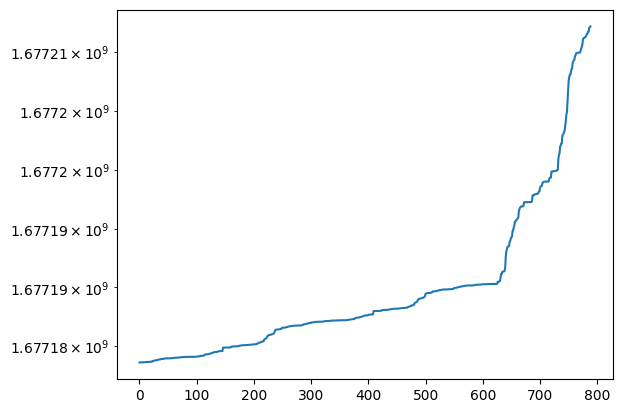

In [14]:
sns.lineplot(x=range(len(df["start_time"])), y=df["start_time"].values)
plt.yscale("log")

In [15]:
print(len(set(df["qname"])))

263


In [16]:
tmp = df[df["qname"] == "8a.sql"]
tmp[["relative_start_time", "qname", "runtime"]]

,relative_start_time,qname,runtime
105,534.276501,8a.sql,12.284534
368,3646.586628,8a.sql,12.147774
631,7256.940049,8a.sql,278.026648


In [17]:
# tmp1 = df[df["relative_start_time"] < 5800]
# tmp2 = df[df["relative_start_time"] >= 5800]
# tmp2 = tmp2[tmp2["relative_start_time"] < 8000]

<AxesSubplot: >

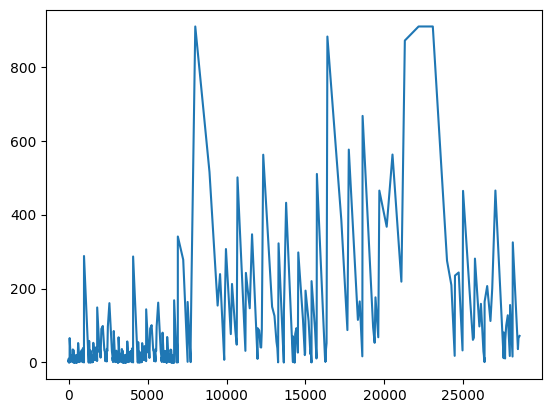

In [18]:
sns.lineplot(x=df["relative_start_time"].values, y=df["runtime"].values)

In [19]:
logfns = glob.iglob(resultdir + "/*/results/sar_logs*")
list(logfns)

['/Users/pari/prism-testbed/LatencyCollectorResults/new/exp3_single/i-0c04efe60b03c66f7/results/sar_logs.csv',
 '/Users/pari/prism-testbed/LatencyCollectorResults/new/exp3_single/i-0c04efe60b03c66f7/results/sar_logs00',
 '/Users/pari/prism-testbed/LatencyCollectorResults/new/exp3_single/i-0c04efe60b03c66f7/results/sar_logs07',
 '/Users/pari/prism-testbed/LatencyCollectorResults/new/exp3_single/i-0c04efe60b03c66f7/results/sar_logs31',
 '/Users/pari/prism-testbed/LatencyCollectorResults/new/exp3_single/i-0c04efe60b03c66f7/results/sar_logs36',
 '/Users/pari/prism-testbed/LatencyCollectorResults/new/exp3_single/i-0c04efe60b03c66f7/results/sar_logs09',
 '/Users/pari/prism-testbed/LatencyCollectorResults/new/exp3_single/i-0c04efe60b03c66f7/results/sar_logs37',
 '/Users/pari/prism-testbed/LatencyCollectorResults/new/exp3_single/i-0c04efe60b03c66f7/results/sar_logs08',
 '/Users/pari/prism-testbed/LatencyCollectorResults/new/exp3_single/i-0c04efe60b03c66f7/results/sar_logs30',
 '/Users/pari/pri

In [20]:
all_logdfs = {}
for exp in EXP_NAMES:
    resultdir = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "new", exp)
    
    #logdfs = {}
    logfns = glob.iglob(resultdir + "/*/results/sar_logs*")
    #print(list(logfns))
    instance_dirs = os.listdir(resultdir)
    for iname in instance_dirs:
        if os.path.isdir(os.path.join(resultdir, iname)):
            all_logdfs[iname] = {}
        else:
            print(iname)
    
    ltdf = pd.read_csv(os.path.join(resultdir, LT_FN), header=None, 
           names=["instance", "lt"])
    ltdf = ltdf.merge(lt_types, on="lt")
    
    for fi, fn in enumerate(logfns):
        instance_name = os.path.basename(os.path.dirname(os.path.dirname(fn)))
        #print(instance_name)
        #all_logdfs[instance_name] = logdfs
        logdfs = all_logdfs[instance_name]

        if ".csv" in fn or "sar_logs00" in fn:
            continue
        try:
            curdf = pd.read_csv(fn, delimiter=";")
            #curdf["instance"] = instance_name
            #curdf = curdf.merge(ltdf, on="instance")
        except Exception as e:
            print("Exception@")
            print(e)
            continue

        if 'kbmemfree' in curdf.keys():
            logdfs["mem"] = curdf
        elif "dropd/s" in curdf.keys():
            logdfs["network1"] = curdf
        elif "%sio-10" in curdf.keys():
            #system load and pressure-stall statistics
            logdfs["pressure_io"] = curdf
        elif 'kbhugfree' in curdf.keys():
            logdfs["hugepg"] = curdf
        elif '%smem-10' in curdf.keys():
            logdfs["pressure_mem"] = curdf
        elif 'kbswpfree' in curdf.keys():
            logdfs["swap"] = curdf
        elif 'idgm6/s' in curdf.keys():
            logdfs["network2"] = curdf
        elif 'bdscd/s' in curdf.keys():
            logdfs["io1"] = curdf
        elif '%irq' in curdf.keys():
            logdfs["cpu_utilization"] = curdf
        elif 'atmptf/s' in curdf.keys():
            logdfs["network3"] = curdf
        elif 'idgm/s' in curdf.keys():
            logdfs["network4"] = curdf
        elif 'areq-sz' in curdf.keys():
            logdfs["device_io"] = curdf
        elif 'call/s' in curdf.keys():
            logdfs["network_nfs"] = curdf
        elif 'rxdrop/s' in curdf.keys():
            logdfs["network5"] = curdf
        elif 'rxcmp/s' in curdf.keys():
            logdfs["network6"] = curdf
        elif 'tcp6sck' in curdf.keys():
            logdfs["network7"] = curdf
        elif 'iseg/s' in curdf.keys():
            logdfs["network8"] = curdf
        elif 'pswpin/s' in curdf.keys():
            logdfs["swap"] = curdf
        elif 'intr/s' in curdf.keys():
            logdfs["interrupts"] = curdf
        elif '%scpu-10' in curdf.keys():
            logdfs["pressure_cpu"] = curdf
        elif 'MHz' in curdf.keys():
            logdfs["power-cpu"] = curdf
        elif 'degC' in curdf.keys():
            logdfs["power-temp"] = curdf
        elif '%ufsused' in curdf.keys():
            logdfs["filesystem"] = curdf
        elif 'cswch/s' in curdf.keys():
            logdfs["context_switch"] = curdf
        elif 'pgpgin/s' in curdf.keys():
            logdfs["paging"] = curdf
        elif 'fwddgm/s' in curdf.keys():
            logdfs["network9"] = curdf
        elif 'ihdrer6/s' in curdf.keys():
            logdfs["network10"] = curdf
        elif 'imsg/s' in curdf.keys():
            logdfs["network11"] = curdf
        elif 'ierr6/s' in curdf.keys():
            logdfs["network12"] = curdf
        elif 'scall/s' in curdf.keys():
            logdfs["network13"] = curdf
        elif 'runq-sz' in curdf.keys():
            logdfs["pressure_load"] = curdf
        elif 'dentunusd' in curdf.keys():
            logdfs["inode"] = curdf
        elif 'igmbq6/s' in curdf.keys():
            logdfs["network14"] = curdf
        elif 'tcpsck' in curdf.keys():
            logdfs["network15"] = curdf
        elif 'otmex/s' in curdf.keys():
            logdfs["network16"] = curdf
        elif 'ihdrerr/s' in curdf.keys():
            logdfs["network17"] = curdf
        elif 'irec6/s' in curdf.keys():
            logdfs["network18"] = curdf
        else:
            assert False

lt_instances.txt
lt_instances.txt
lt_instances.txt


In [21]:
print("Number of log files: ", len(logdfs))

todel = []
for instance,logdfs in all_logdfs.items():
    keys = list(logdfs.keys())
    tmp = df[df["instance"] == instance]
    if len(tmp) == 0:
        todel.append(instance)
        
for td in todel:
    del all_logdfs[td]

for instance,logdfs in all_logdfs.items():
    print(instance, len(logdfs))
    keys = list(logdfs.keys())
    tmp = df[df["instance"] == instance]

    min_qtime = min(tmp["start_time"].values)
    max_qtime = max(tmp["start_time"].values)

    for k in keys:
        if "network" in k:
            del logdfs[k]
            continue
        if "hugepg" in k:
            del logdfs[k]
            continue

        if len(logdfs[k]) == 0:
            continue

        mincur = min(logdfs[k]["timestamp"])
        logdfs[k]["relative_time"] = logdfs[k].apply(lambda x: x["timestamp"]-min_qtime , axis=1)
        logdfs[k] = logdfs[k][logdfs[k]["relative_time"] >= -10.0]
        
print("Number of log files w/o networking: ", len(logdfs))

Number of log files:  36
i-0b5cab95e080938d5 36
Number of log files w/o networking:  16


In [22]:
for instance,logdfs in all_logdfs.items():
    print(logdfs.keys())
    print(min(logdfs["mem"]["relative_time"]))

dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])
-3.616631507873535


In [23]:
print(all_logdfs.keys())
print(set(df["instance"]))

dict_keys(['i-0b5cab95e080938d5'])
{'i-0b5cab95e080938d5'}


In [24]:
total = 0
for ldf in logdfs:
    print(ldf, logdfs[ldf].keys())
    total += len(logdfs[ldf].keys())

print("Num data points per timestamp: ", total)

mem Index(['# hostname', 'interval', 'timestamp', 'kbmemfree', 'kbavail',
       'kbmemused', '%memused', 'kbbuffers', 'kbcached', 'kbcommit', '%commit',
       'kbactive', 'kbinact', 'kbdirty', 'kbanonpg', 'kbslab', 'kbkstack',
       'kbpgtbl', 'kbvmused', 'relative_time'],
      dtype='object')
pressure_io Index(['# hostname', 'interval', 'timestamp', '%sio-10', '%sio-60', '%sio-300',
       '%sio', '%fio-10', '%fio-60', '%fio-300', '%fio', 'relative_time'],
      dtype='object')
pressure_mem Index(['# hostname', 'interval', 'timestamp', '%smem-10', '%smem-60',
       '%smem-300', '%smem', '%fmem-10', '%fmem-60', '%fmem-300', '%fmem',
       'relative_time'],
      dtype='object')
swap Index(['# hostname', 'interval', 'timestamp', 'pswpin/s', 'pswpout/s',
       'relative_time'],
      dtype='object')
io1 Index(['# hostname', 'interval', 'timestamp', 'tps', 'rtps', 'wtps', 'dtps',
       'bread/s', 'bwrtn/s', 'bdscd/s', 'relative_time'],
      dtype='object')
cpu_utilization Index([

# Interrupts / s

In [25]:
logdfs["interrupts"].groupby("INTR")["intr/s"].describe()

,count,mean,std,min,25%,50%,75%,max
INTR,,,,,,,,
-1,6111.0,223.392852,453.338581,14.2,23.4,31.5,184.0,4834.6
0,6111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,6111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,6111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,6111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
435,6111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
436,6111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
437,6111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


# PageFaults / s

In [26]:
# pgdf = logdfs["paging"]
# sns.lineplot(x=pgdf["relative_time"], y=pgdf["fault/s"].values)

<AxesSubplot: >

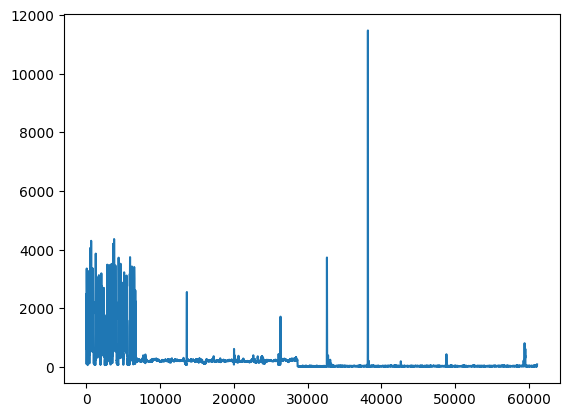

In [27]:
cdf = logdfs["context_switch"]
sns.lineplot(x=cdf["relative_time"].values, y=cdf["cswch/s"].values)

In [28]:
# powdf = logdfs["power-temp"]
# sns.lineplot(x=range(len(powdf)), y=powdf["degC"].values)

In [29]:
# powcpu = logdfs["power-cpu"]
# sns.lineplot(x=range(len(powcpu)), y=powcpu["MHz"].values)

In [37]:
pcpu = logdfs["pressure-cpu"]
sns.lineplot(x=pcpu["relative_time"].values, y=pcpu["%scpu"].values)

KeyError: 'pressure-cpu'

In [35]:
memdf.keys()

Index(['# hostname', 'interval', 'timestamp', 'kbmemfree', 'kbavail',
       'kbmemused', '%memused', 'kbbuffers', 'kbcached', 'kbcommit', '%commit',
       'kbactive', 'kbinact', 'kbdirty', 'kbanonpg', 'kbslab', 'kbkstack',
       'kbpgtbl', 'kbvmused', 'relative_time'],
      dtype='object')

In [33]:
memdf = logdfs["mem"]
sns.lineplot(x=memdf["relative_time"], y=memdf["%fmem-300"].values)

KeyError: '%fmem-300'

In [36]:
logdfs.keys()

dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])

<AxesSubplot: xlabel='relative_start_time', ylabel='runtime'>

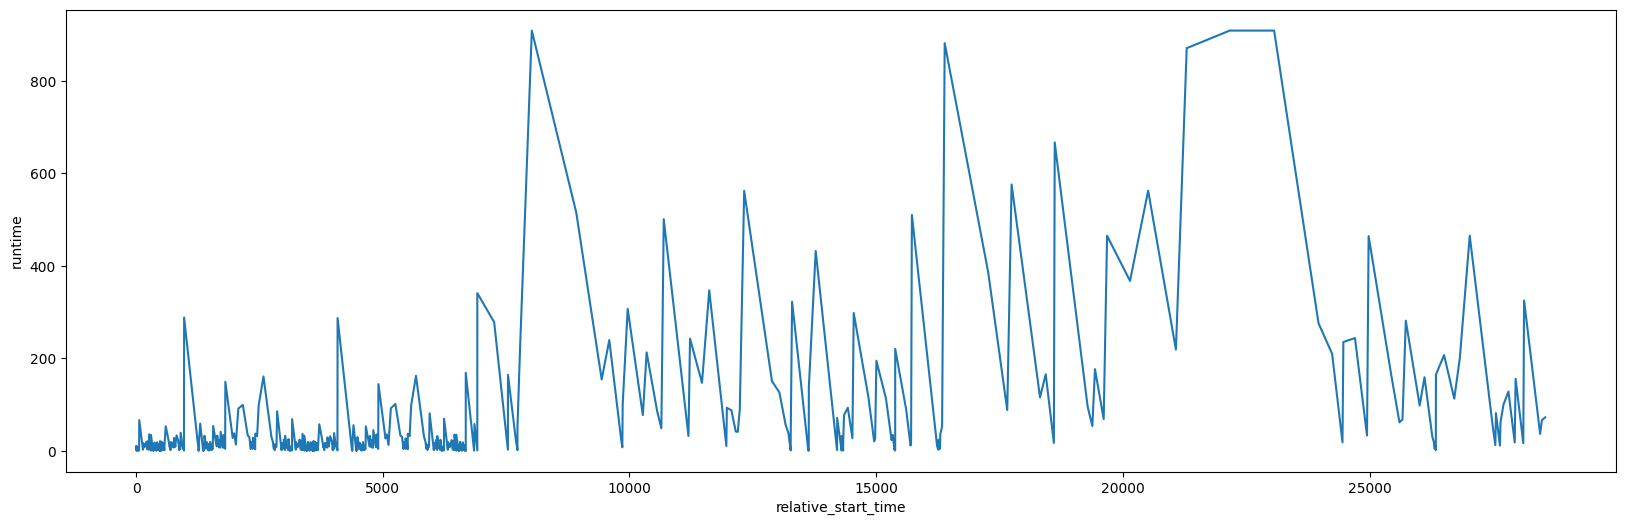

In [34]:
fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
sns.lineplot(data=df, x="relative_start_time", y = "runtime", ax=axs)

In [35]:
# tmp = df[df["runtime"] <= 900.0]

# fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
# sns.lineplot(data=tmp, x="relative_start_time", y = "runtime", ax=axs)

In [36]:
# tmp = df[df["runtime"] <= 900.0]

# fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
# sns.histplot(data=tmp, x="relative_start_time", y = "runtime", stat="count", bins=1000, ax=axs)

<AxesSubplot: xlabel='relative_start_time', ylabel='runtime'>

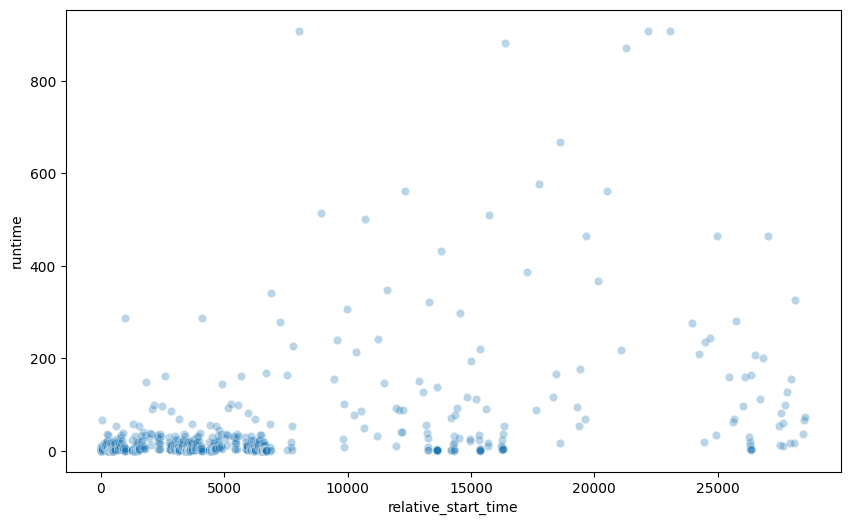

In [37]:
#tmp = df[df["runtime"] <= 900.0]

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.scatterplot(data=df, x="relative_start_time", y = "runtime", ax=ax, alpha=0.3)


In [38]:
logdfs["device_io"].groupby(["DEV"])["areq-sz"].describe()

,count,mean,std,min,25%,50%,75%,max
DEV,,,,,,,,
loop0,6111.0,0.337378,4.222298,0.00,0.00,0.00,0.0,79.50
loop1,6111.0,0.000532,0.031495,0.00,0.00,0.00,0.0,2.25
loop2,6111.0,0.000913,0.043358,0.00,0.00,0.00,0.0,2.33
loop3,6111.0,0.000368,0.028782,0.00,0.00,0.00,0.0,2.25
loop4,6111.0,0.017611,0.985225,0.00,0.00,0.00,0.0,66.40
loop5,6111.0,0.012332,0.663353,0.00,0.00,0.00,0.0,39.00
loop6,2848.0,0.003869,0.148618,0.00,0.00,0.00,0.0,7.50
loop7,2847.0,0.003319,0.141361,0.00,0.00,0.00,0.0,7.20
nvme0n1,6111.0,11.105181,9.965309,4.28,6.87,8.59,12.0,245.00


In [39]:
print(min(logdfs["paging"]["timestamp"].values), max(logdfs["paging"]["timestamp"].values))
mins = min(logdfs["paging"]["timestamp"].values)
maxs = max(logdfs["paging"]["timestamp"].values)

1677183619 1677244719


In [40]:
print(min(df["start_time"].values), max(df["start_time"].values))
mins2 = min(df["start_time"].values)
maxs2 = max(df["start_time"].values)

1677183622.6166315 1677212181.8479743


In [41]:
"Seconds after which we started executing queries: ", mins2 - mins

('Seconds after which we started executing queries: ', 3.616631507873535)

In [42]:
"Seconds after which we finished executing queries: ", maxs - maxs2

('Seconds after which we finished executing queries: ', 32537.152025699615)

In [43]:
"Seconds for total sys logging: ", maxs - mins

('Seconds for total sys logging: ', 61100)

In [26]:
"Seconds for total query executions: ", maxs2 - mins2

NameError: name 'maxs2' is not defined

In [27]:
print(len(set(df["qname"])))

263


In [70]:
logdfs.keys()

dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])

In [45]:
logdfs["swap"].keys()

Index(['# hostname', 'interval', 'timestamp', 'pswpin/s', 'pswpout/s',
       'relative_time'],
      dtype='object')

In [40]:
df.keys()

Index(['start_time', 'qname', 'runtime', 'exp_analyze', 'samples_type',
       'parallel_workers', 'no_index', 'drop_cache', 'col_store', 'result_dir',
       'query_dir', 'cost_model', 'materialize', 'explain', 'reps',
       'num_queries', 'timeout', 'rerun_timeouts', 'db_name', 'db_host',
       'user', 'pwd', 'port', 'instance', 'lt', 'lt_type',
       'relative_start_time', 'workload'],
      dtype='object')

In [41]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# def plot_logs(df, logdfs, key1, key2):
#     fig, ax = plt.subplots(3, 1, figsize=(6, 15))

#     # Scatter plot for runtime latency
#     sns.scatterplot(data=df, x='relative_start_time', y='runtime', hue='qname', ax=ax[0], legend=False)
#     ax[0].set_title('Runtime Latency Scatter Plot')
#     ax[0].set_xlabel('Relative Start Time')
#     ax[0].set_ylabel('Runtime')

#     # Line plot for the first key
#     sns.lineplot(data=logdfs[key1[0]], x='relative_time', y=key1[1], ax=ax[1], 
#                  errorbar=None) # Using the 4th column for plotting
#     ax[1].set_title(f'Log Plot for {key1}')
#     ax[1].set_xlabel('Relative Time')
#     ax[1].set_ylabel(key1)

#     # Line plot for the second key
#     sns.lineplot(data=logdfs[key2[0]], x='relative_time', y=key2[1], ax=ax[2], 
#                 errorbar=None) # Using the 4th column for plotting
#     ax[2].set_title(f'Log Plot for {key2}')
#     ax[2].set_xlabel('Relative Time')
#     ax[2].set_ylabel(key2)

#     plt.tight_layout()
#     plt.show()

# # Call the function
# plot_logs(df, logdfs, ('device_io', 'await'), ('cpu_utilization', '%usr'))  # You can replace 'mem' and 'pressure_io' with any keys you're interested in


<AxesSubplot: xlabel='relative_time', ylabel='await'>

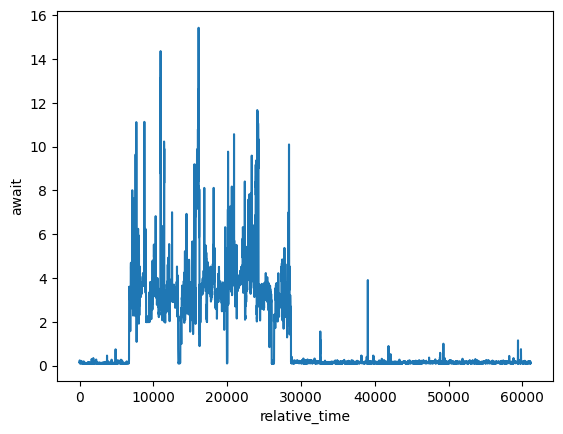

In [42]:
sns.lineplot(data=logdfs["device_io"], x='relative_time', y="await", errorbar=None)

<AxesSubplot: xlabel='relative_time', ylabel='%fmem-300'>

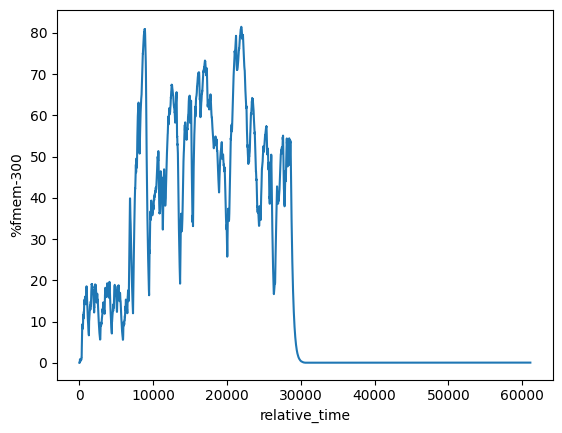

In [43]:
sns.lineplot(data=logdfs["pressure_mem"], x='relative_time', y="%fmem-300", errorbar=None)

<AxesSubplot: xlabel='relative_time', ylabel='%smem-300'>

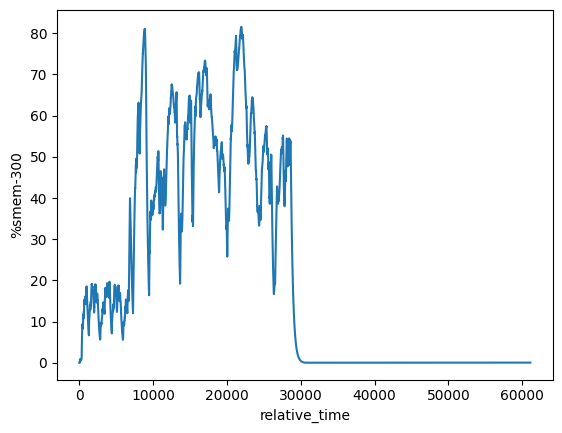

In [48]:
sns.lineplot(data=logdfs["pressure_mem"], x='relative_time', y="%smem-300", errorbar=None)

<AxesSubplot: xlabel='relative_time', ylabel='pswpout/s'>

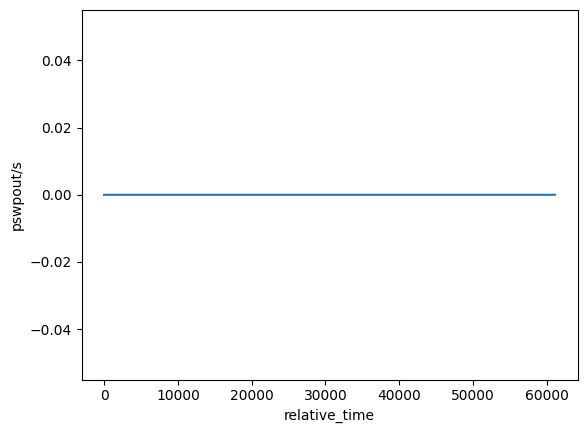

In [49]:
sns.lineplot(data=logdfs["swap"], x='relative_time', y="pswpout/s", errorbar=None)

In [50]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# import matplotlib.gridspec as gridspec

# def plot_logs(df, logdfs, key1, key2, fn, query_list=None, x_min=None, x_max=None):

#     # Filter dataframe based on the provided query list
#     if query_list:
#         df = df[df['qname'].isin(query_list)]
    
#     # Using GridSpec for custom subplot layout
#     fig = plt.figure(figsize=(3.5, 6))
#     gs = gridspec.GridSpec(4, 1)  # 4 rows, 1 column

#     ax0 = plt.subplot(gs[0:2])  # First plot takes first 2 rows
#     ax1 = plt.subplot(gs[2])    # Second plot takes the third row
#     ax2 = plt.subplot(gs[3])    # Third plot takes the fourth row
#     ax = [ax0, ax1, ax2]  # List of axes for convenience
    
#     #fig, ax = plt.subplots(3, 1, figsize=(3.5, 6), sharex=True)
    
#     # Set stronger color palette
#     sns.set_palette("deep")

#     # Remove top and right spines
#     sns.despine()

#     # Scatter plot for runtime latency with increased point size
#     sns.scatterplot(data=df, x='relative_start_time', y='runtime', hue='qname', ax=ax[0], 
#                     legend='brief', s=50)
    
#     handles, labels = ax[0].get_legend_handles_labels()
    
#     print(labels)
#     # Filter out labels with no ".sql" and truncate those that are too long
#     truncated_labels = []
#     filtered_handles = []
#     for li, label in enumerate(labels):
#         handle = handles[li]
#         if len(label) > 10:
#             truncated_label = label[:6] + ".sql"
#         elif ".sql" not in label:
#             continue
#         else:
#             truncated_label = label
            
#         filtered_handles.append(handle)
#         truncated_labels.append(truncated_label)
    
#     print(truncated_labels)
#     ax[0].legend(handles=filtered_handles, labels=truncated_labels, 
#                  loc='upper left', fontsize=8, frameon=False, 
#                  bbox_to_anchor=(0, 1.2), ncols=2)

    
#     ax[0].set_xlabel('')  # remove x-label for the first two plots
#     ax[0].set_ylabel('query latency (s)', fontsize=12)
#     ax[0].tick_params(axis='y', labelsize=10)
#     ax[0].grid(True, linestyle='--', alpha=0.5)
#     ax[0].set_ylim(0.1, 600)
#     ax[0].set_yscale("log")
    
#     # Line plot for the first key
#     sns.lineplot(data=logdfs[key1[0]], x='relative_time', y=key1[1], ax=ax[1], errorbar=None, color="blue")
#     ax[1].set_xlabel('')  # remove x-label for the first two plots
#     ax[1].set_ylabel(key1[0] + "-" + key1[1], fontsize=12)
#     ax[1].tick_params(axis='y', labelsize=10)
#     ax[1].grid(True, linestyle='--', alpha=0.5)
    
#     # Line plot for the second key
#     sns.lineplot(data=logdfs[key2[0]], x='relative_time', y=key2[1], ax=ax[2], errorbar=None, color="blue")
#     ax[2].set_xlabel('Relative Start Time', fontsize=12)
#     ax[2].set_ylabel("cpu" + "-" + key2[1], fontsize=12)
#     ax[2].tick_params(axis='y', labelsize=10)
#     ax[2].grid(True, linestyle='--', alpha=0.5)
    
#     # Setting x-axis limits if provided
#     if x_min is not None and x_max is not None:
#         for axis in ax:
#             axis.set_xlim(x_min, x_max)
    
#     fig.subplots_adjust(hspace=0.25)  # adjust space between plots
    
#     # After plotting, set shared x-axis properties
#     ax[1].sharex(ax[0])
#     ax[2].sharex(ax[0])

    
#     plt.tight_layout()
#     plt.savefig(fn)
    
#     plt.show()


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

def plot_logs(df, logdfs, key1, key2, fn, query_list=None, x_min=None, x_max=None):
    # Using GridSpec for custom subplot layout
    fig = plt.figure(figsize=(3.5, 6))
    gs = gridspec.GridSpec(4, 1)  # 4 rows, 1 column

#     ax0 = plt.subplot(gs[0:2])  # First plot takes first 2 rows
#     ax1 = plt.subplot(gs[2])    # Second plot takes the third row
#     ax2 = plt.subplot(gs[3])    # Third plot takes the fourth row
#     ax = [ax0, ax1, ax2]  # List of axes for convenience
    
    ax0 = plt.subplot(gs[0:2])  # First plot takes first 2 rows
    ax1 = plt.subplot(gs[2], sharex=ax0)    # Second plot takes the third row
    ax2 = plt.subplot(gs[3], sharex=ax0)    # Third plot takes the fourth row
    ax = [ax0, ax1, ax2]  # List of axes for convenience

    # Set stronger color palette
    sns.set_palette("deep")

    # Remove top and right spines
    sns.despine()

    # First, plot all data points in gray with reduced alpha
    sns.scatterplot(data=df, x='relative_start_time', y='runtime', ax=ax[0], color="gray", alpha=0.5, s=50)

    # Next, overlay only the data points from query_list using the hue argument
    if query_list:
        df_highlight = df[df['qname'].isin(query_list)]
        sns.scatterplot(data=df_highlight, x='relative_start_time', y='runtime', hue='qname', ax=ax[0], 
                        legend='brief', s=100)
    
        handles, labels = ax[0].get_legend_handles_labels()
        #truncated_labels = [label[:6] + ("..." if len(label) > 6 else "") for label in labels if ".sql" in label]
    
        print(labels)
        # Filter out labels with no ".sql" and truncate those that are too long
        truncated_labels = []
        filtered_handles = []
        for li, label in enumerate(labels):
            handle = handles[li]
            if len(label) > 10:
                truncated_label = label[:6] + ".sql"
            elif ".sql" not in label:
                continue
            else:
                truncated_label = label

            filtered_handles.append(handle)
            truncated_labels.append(truncated_label)

        print(truncated_labels)
        
        ax[0].legend(handles=filtered_handles, labels=truncated_labels, 
             loc='upper left', fontsize=8, frameon=False, 
             bbox_to_anchor=(0, 1.1), ncols=2)
        
    else:
        ax[0].legend([], [], frameon=False)

    ax[0].set_xlabel('')  # remove x-label for the first two plots
    ax[0].set_ylabel('query latency (s)', fontsize=12)
    ax[0].tick_params(axis='y', labelsize=10)
    ax[0].grid(True, linestyle='--', alpha=0.2)
    ax[0].set_ylim(0.1, 950)
    ax[0].set_yscale("log")
    
    # Line plot for the first key
    sns.lineplot(data=logdfs[key1[0]], x='relative_time', y=key1[1], ax=ax[1], 
                 errorbar=None, color="blue")
    ax[1].set_xlabel('')  # remove x-label for the first two plots
    #ax[1].set_ylabel(key1[0] + "-" + key1[1], fontsize=12)
    
    ax[1].set_ylabel(key1[1], fontsize=12)
    ax[1].tick_params(axis='y', labelsize=10)
    ax[1].grid(True, linestyle='--', alpha=0.5)
    ax[1].set_ylim([0,16])
    
    # Line plot for the second key
    sns.lineplot(data=logdfs[key2[0]], x='relative_time', y=key2[1], ax=ax[2], errorbar=None, color="blue")
    ax[2].set_xlabel('experiment time', fontsize=12)
    ax[2].set_ylabel(key2[1], fontsize=12)
    ax[2].tick_params(axis='y', labelsize=10)
    ax[2].grid(True, linestyle='--', alpha=0.5)
    
    # Hide the x-axis ticks and labels for the first two plots
    ax0.set_xticks([])
    ax1.set_xticks([])
    
    # Setting x-axis limits if provided
    if x_min is not None and x_max is not None:
        for axis in ax:
            axis.set_xlim(x_min, x_max)
    
    fig.subplots_adjust(hspace=0.0)  # adjust space between plots
    
    # After plotting, set shared x-axis properties
    ax[1].sharex(ax[0])
    ax[2].sharex(ax[0])

    plt.tight_layout()
    plt.savefig(fn)
    plt.show()

In [52]:
QNAMES = [#"7a121.sql",
         #"7a131.sql", "7a160.sql", "6a447.sql", "6a26.sql", 
         "7c.sql",
         "8b.sql",
         "05d86a8dd0274da78805545a176079f8e14f7e7d.sql",
         ]

['7c.sql', '8b.sql', '05d86a8dd0274da78805545a176079f8e14f7e7d.sql']
['7c.sql', '8b.sql', '05d86a.sql']


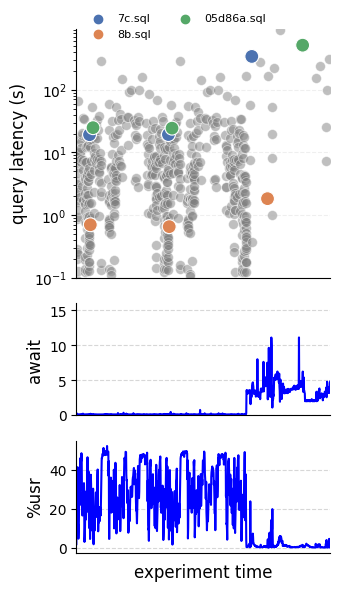

In [53]:
fn = "variable_latencies_intuition.pdf"
plot_logs(df, logdfs, ("device_io", "await"), ("cpu_utilization", "%usr"), fn, query_list=QNAMES, 
          x_min=0, x_max=10000)

['7c.sql', '8b.sql', '05d86a8dd0274da78805545a176079f8e14f7e7d.sql']
['7c.sql', '8b.sql', '05d86a.sql']


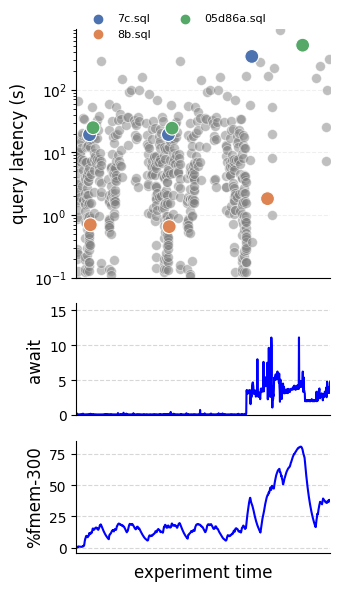

In [55]:
fn = "variable_latencies_intuition.pdf"
plot_logs(df, logdfs, ("device_io", "await"), ("pressure_mem", "%fmem-300"), fn, query_list=QNAMES, 
          x_min=0, x_max=10000)

In [105]:
tmp = df[df["qname"].isin(QNAMES)]
tmp["runtime"]

104     19.182211
208     32.518711
212     40.461276
221     36.119151
222     90.920321
223     98.768152
367     19.293121
471     31.787692
475     44.223063
484     34.551080
485     91.468770
486    100.987622
630    340.786287
734    575.924588
738    667.057322
747    870.931981
748    909.000000
749    909.000000
Name: runtime, dtype: float64

In [83]:
logdfs["device_io"]

3340     0.00
3341     0.00
3342     0.00
3343     0.00
3344     0.00
         ... 
70140    0.00
70141    0.70
70142    0.71
70143    0.00
70144    0.00
Name: await, Length: 66805, dtype: float64

# Per query plots

In [453]:
reset_output()
output_notebook()

reset_output()
#output_notebook()

FN_TMP = "./{EXP_NAME}/{QNAME}.html"
TITLE_FMT = "{QUERY}.\n Start:{START}.\n Latency:{LAT}."
COLS = 2

make_dir(EXP_NAME)

plot_data = {}

for qi, qname in enumerate(list(set(df["qname"]))):
#     if qi >= 2:
#         break
    
    fn = FN_TMP.format(EXP_NAME=EXP_NAME, QNAME=qname.replace(".sql", ""))
    output_file(fn)
    print(fn)
    
    tmp = df[df["qname"] == qname]
    tmp = tmp.sort_values(by="relative_start_time")
    allplots = []
    
    for ei, exp in enumerate(tmp["exp_analyze"].values):
        try:
            plan = eval(str(exp))
            #print(plan)
        except Exception as e:
            print(e)
            continue
        
        lat = tmp["runtime"].values[ei]
        stime = tmp["relative_start_time"].values[ei]
        title = TITLE_FMT.format(QUERY=qname, START=stime, LAT = lat)

        G = explain_to_nx(plan[0][0][0])
        #print(len(G.nodes()))
        aliases = extract_values(plan[0][0][0], "Alias")
        #print(aliases)

        p1 = bokeh_plot(G, showplot=False,  height=600, width=800, title=title)
        p1.visible = True
        allplots.append(p1)
        
    allrows = []
    num_rows = math.ceil(len(allplots) / COLS)
    
    for i in range(num_rows):
        allrows.append(row(allplots[i*COLS:i*COLS+COLS]))
    
    save(column(allrows))
    #show(column(row(allplots[0:3]), row(allplots[3:6]), row(allplots[6:9])))

Loading BokehJS ...

./t7xlarge-gp3-d/29c.html
./t7xlarge-gp3-d/25b.html
./t7xlarge-gp3-d/23a.html
./t7xlarge-gp3-d/2a714.html
./t7xlarge-gp3-d/6de21f7b6d08d84073c7496dbff73afba95d7c8d.html
./t7xlarge-gp3-d/30b.html
./t7xlarge-gp3-d/18a.html
./t7xlarge-gp3-d/11d.html
./t7xlarge-gp3-d/26b.html
./t7xlarge-gp3-d/24b.html
./t7xlarge-gp3-d/4a143.html
./t7xlarge-gp3-d/32b1cf5e7af7bd6231e2d73a1b56ecf21bbd9804.html
./t7xlarge-gp3-d/3a76.html
./t7xlarge-gp3-d/7a58.html
./t7xlarge-gp3-d/29a.html
./t7xlarge-gp3-d/7045b4dac1171674c69f224b25c3c73ad8d9ca03.html
./t7xlarge-gp3-d/19a.html
./t7xlarge-gp3-d/408f3f94c386672c03af6b01705edab10554bba2.html
./t7xlarge-gp3-d/1a972.html
./t7xlarge-gp3-d/3a315.html
./t7xlarge-gp3-d/1c.html
./t7xlarge-gp3-d/16d.html
./t7xlarge-gp3-d/2c99.html
./t7xlarge-gp3-d/32a.html
./t7xlarge-gp3-d/5b.html
./t7xlarge-gp3-d/8c.html
./t7xlarge-gp3-d/be5f621ca67267a999a86e6b9843728d6992d649.html
./t7xlarge-gp3-d/2a620.html
./t7xlarge-gp3-d/3ebf44254fc9a2ae77481169131fd0ab111a6c43.html
./t7xlarge-gp3

./t7xlarge-gp3-d/20a.html
./t7xlarge-gp3-d/8a400.html
./t7xlarge-gp3-d/2a245.html
./t7xlarge-gp3-d/8d.html
./t7xlarge-gp3-d/30c.html
./t7xlarge-gp3-d/6a508.html
./t7xlarge-gp3-d/15d.html
./t7xlarge-gp3-d/728f1ee9b87457c8b28490639330db5b8f5b1e1c.html
./t7xlarge-gp3-d/6a338.html
./t7xlarge-gp3-d/61959f7b7fcd01bb21afed4e91a731fb1e4f5a14.html
./t7xlarge-gp3-d/1a761.html
./t7xlarge-gp3-d/1a1974.html
./t7xlarge-gp3-d/e8c1806d3f6d16369058ed9c40cc6b4e2e56676e.html
./t7xlarge-gp3-d/2a348.html
./t7xlarge-gp3-d/cd252c4d15a8d118c1aae28bd1ec48c7f45584b2.html
./t7xlarge-gp3-d/14a.html
./t7xlarge-gp3-d/2c192.html
./t7xlarge-gp3-d/5a686.html
./t7xlarge-gp3-d/7a160.html


In [321]:
src.groupby("relative_time").mean().reset_index()

,relative_time,timestamp
0,0,1674686716
1,10,1674686726
2,20,1674686736
3,30,1674686746
4,40,1674686756
...,...,...
2280,22810,1674709526
2281,22820,1674709536
2282,22830,1674709546
2283,22840,1674709556


In [116]:
print(logdfs.keys())
print(len(logdfs.keys()))

dict_keys(['mem', 'pressure1', 'pressure2', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure-cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure-load', 'inode'])
16


In [644]:
logdfs["mem"].keys()

Index(['# hostname', 'interval', 'timestamp', 'kbmemfree', 'kbavail',
       'kbmemused', '%memused', 'kbbuffers', 'kbcached', 'kbcommit', '%commit',
       'kbactive', 'kbinact', 'kbdirty', 'kbanonpg', 'kbslab', 'kbkstack',
       'kbpgtbl', 'kbvmused'],
      dtype='object')

In [643]:
logdfs.keys()

dict_keys(['mem', 'pressure1', 'hugepg', 'pressure2', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure-cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure-load', 'inode'])